
# **TWEET CLASSIFICATION USING BERT**


## Install and loading libraries

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.9 MB/s eta 0:00:00


In [ ]:
import numpy as np # for scientific computing
import pandas as pd # for working with data
import seaborn as sns # extension of matplotlib
import matplotlib.pyplot as plt #plots graphs
import nltk
import re    # for regular expressions
import nltk  # for text manipulation
import os

# Library for preprocessing data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Model
from transformers import BertTokenizer,TFBertForSequenceClassification
import tensorflow as tf
from tensorflow import keras

# Library for evaluate model
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# **I. Read in data and quick EDA**


## Training dataset


In [ ]:
# Read in data training data
df_train = pd.read_csv('./datasets/train_tweets.csv')
print("TRAINING DATASET: ",df_train.shape)


TRAINING DATASET:  (31962, 3)


In [ ]:
df_train.head()


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


## Test dataset

In [ ]:
# Read in data training data
df_test = pd.read_csv('./datasets/test_tweets.csv')
print("TEST DATASET: ", df_test.shape)

TEST DATASET:  (17197, 2)


In [ ]:
df_test.head()


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


Training dataset have: 21602 rows and 3 collumns.

Test dataset have : 17197 rows and 2 collumns.

**Meaning of collumns:**
* `id`: the tweet ID
* `tweet`:  the tweet content.
* `label`: only present in the training data, indicating whether the tweet is racist or not. (0) represents non-racist, and (1) represents racist.

## Data distribution by label of training dataset

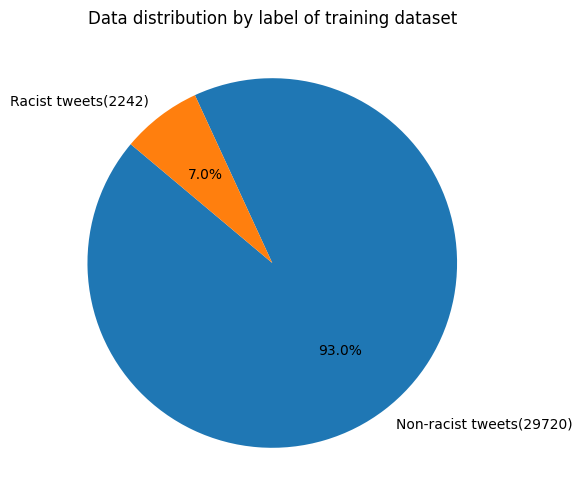

In [ ]:
#Create pie chart for data distribution by label of training dataset
plt.figure(figsize=(6, 6))
train_label_counts = df_train['label'].value_counts()
plt.pie(train_label_counts,labels=['Non-racist tweets({})'.format(train_label_counts[0]),'Racist tweets({})'.format(train_label_counts[1])],
        autopct='%1.1f%%', startangle=140)
plt.title('Data distribution by label of training dataset')
plt.show()


# **II. PREPROCESSING DATA**

### Apply some text preprocessing steps:
* Stemming and lemmatization.
* Convert uppercase letters to lowercase.
* Expand abbreviations to full words.
* Remove non-ASCII characters.
* Remove stopwords.


In [ ]:
nltk.download('punkt') # data for tokenization
nltk.download('stopwords') # data for stopwords
nltk.download('wordnet') # data for lenmatization


# Initialize a stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

abbreviations = {}
with open('abbreviations.txt', 'r') as file:
    for line in file:
        abbreviation, full_form = line.strip().split(':')
        abbreviations[abbreviation] = full_form

#user-defined function to remove unwanted text patterns from the tweets.
def remove_pattern(input_txt, pattern):
    #Finds all words matching the pattern
    r = re.findall(pattern, input_txt)
    for i in r:
        #removes the matched words
        input_txt = re.sub(i, '', input_txt)
    return input_txt

def preprocess_text(text):

    # Removing user tags because they appear so much and
    # have less meaning in the analysis
    text = remove_pattern(text, "@[\w]*")
    # Tokenize the text
    words = word_tokenize(text)

    # Stemming and lemmatization
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]

    # Convert words to lowercase
    words = [word.lower() for word in words]

    # Replace abbreviations with their full forms
    words = [abbreviations.get(word, word) for word in words]

    # Remove special characters and numbers
    words = [re.sub(r'[^a-zA-Z]', '', word) for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df_train['preprocessed_tweet'] = df_train['tweet'].apply(preprocess_text)
df_test['preprocessed_tweet'] = df_test['tweet'].apply(preprocess_text)

In [ ]:
df_train.head(10)

,id,label,tweet,preprocessed_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag hi kid hi dysfunc...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank lyft credit ca use caus offer wheelchair...
2,3,0,bihday your majesty,bihday majesti
3,4,0,#model i love u take with u all the time in ...,model love take time
4,5,0,factsguide: society now #motivation,factsguid societi motiv
5,6,0,[2/2] huge fan fare and big talking before the...,huge fan fare big talk befor leav chao pay dis...
6,7,0,@user camping tomorrow @user @user @user @use...,camp tomorrow
7,8,0,the next school year is the year for exams.ð...,next school year year ca think school exam hat...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,love land allin cav champion cleveland clevela...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcom great


## Visualizing the frequency of words after preprocessing


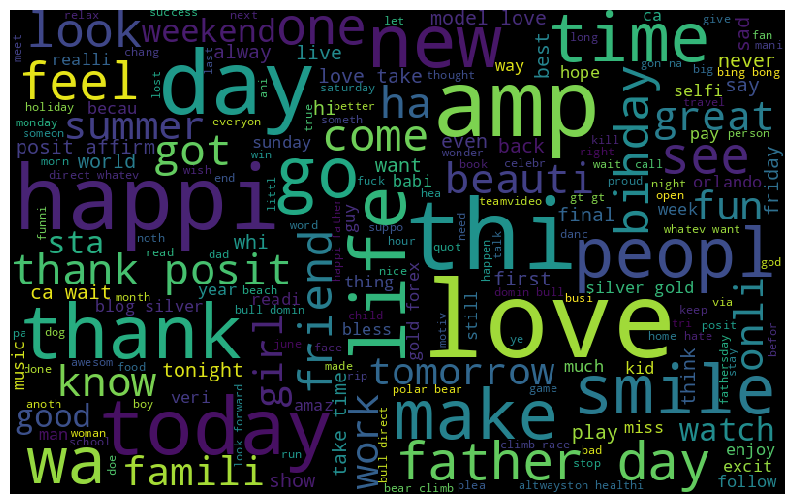

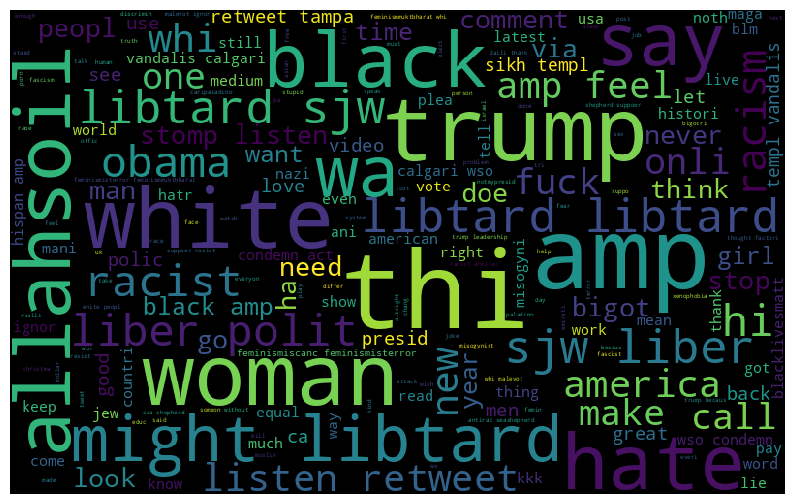

In [ ]:
from wordcloud import WordCloud #To use wordcloud
#VISUALIZATION FROM TWEETS

#word cloud visualization is used to identify frequency of words

#Non-racist tweets
    #Taking non - racist tweets
normal_words =' '.join([text for text in df_train['preprocessed_tweet'][df_train['label'] == 0]])
    #Generating word cloud
wordcloud = WordCloud(width=800, height=500, random_state=11, max_font_size=110).generate(normal_words)
    #Plotting word cloud in graph
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="none")
plt.axis('off')
plt.show()


#Racist tweets
    #Taking non - racist tweets
normal_words =' '.join([text for text in df_train['preprocessed_tweet'][df_train['label'] == 1]])
    #Generating word cloud
wordcloud = WordCloud(width=800, height=500, random_state=11, max_font_size=110).generate(normal_words)
    #Plotting word cloud in graph
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="none")
plt.axis('off')
plt.show()


# **III. BERT Model for Tweet classification**

In [ ]:
train_text = df_train.preprocessed_tweet
train_label = df_train.label

In [ ]:
test_text = df_test.preprocessed_tweet

### Using the pretrained bert-base-uncased to tokenize text into vectors

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# Tokenize text to vectors
token_lens = []
for txt in list(train_text):
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

Here, max_length = 512 will limit the length of each sentence. If any sentence is longer than 512, it will be truncated (truncation = True). However, there are no sentences in the entire corpus that are that long. Let's examine their distribution on the training set.

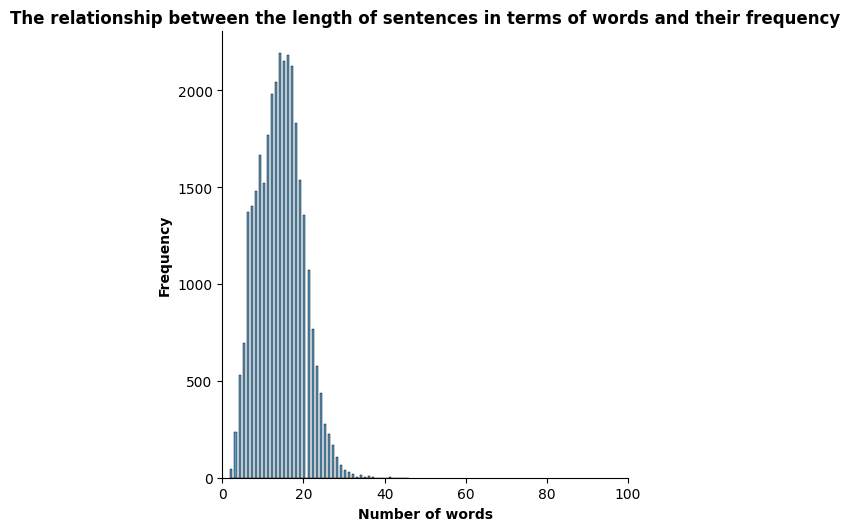

In [ ]:
sns.displot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Number of words', fontweight = "bold")
plt.ylabel('Frequency', fontweight = "bold")
plt.title("The relationship between the length of sentences in terms of words and their frequency", fontweight = "bold")
plt.show()

Based on the graph, we will choose the hyperparameter `max_length` = 14 or 12 to train the model.



### Convert text into vectors using the vocabulary from the pretrained bert-base-uncased model,

In [ ]:
MAX_SEQ_LEN = 14

def bert_tokenizer(text):
    encoding = tokenizer.encode_plus(
    text,
    max_length=MAX_SEQ_LEN,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['input_ids'][0], encoding['attention_mask'][0]

In [ ]:
bert_tokenizer("camp tomorrow")

(tensor([ 101, 3409, 4826,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]),
 tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
# train data tokenization
train_tokenized_list = []
train_attn_mask_list = []
for text in list(train_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    train_tokenized_list.append(tokenized_text.numpy())

In [ ]:
# test data tokenization for testing
test_tokenized_list = []
test_attn_mask_list = []
for text in list(test_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    test_tokenized_list.append(tokenized_text.numpy())

Convert `train_tokenized_list` and `test_tokenized_list` to dataframe.

In [ ]:
train_tokenised_text_df = pd.DataFrame(train_tokenized_list)
test_tokenised_text_df = pd.DataFrame(test_tokenized_list)

#### Fine-tune the Pretrained BERT model on `X_train` (80% of data) and evaluate it on `X_val` (20% of data) with 10 epochs

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_tokenised_text_df, train_label, test_size=0.2, random_state=4)


In [ ]:

print(f'X_train input shape {X_train.shape}, train label shape {y_train.shape}')
print(f'X_val input shape {X_val.shape}, validation label shape {y_val.shape}')

X_train input shape (25569, 14), train label shape (25569,)
X_val input shape (6393, 14), validation label shape (6393,)


In [ ]:
bertClassifier = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)
print('\nBert Model', bertClassifier.summary())

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Bert Model None


In [ ]:
checkpoint_path = "./models/my_bert.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 verbose=1)



loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bertClassifier.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
bertHistory = bertClassifier.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=10,
                       validation_data=(X_val, y_val),
                       callbacks=[model_callback])

Epoch 1/10
800/800 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9475
Epoch 1: val_loss improved from inf to 0.12926, saving model to ./models/my_bert.ckpt
800/800 [==============================] - 222s 216ms/step - loss: 0.1629 - accuracy: 0.9475 - val_loss: 0.1293 - val_accuracy: 0.9575
Epoch 2/10
800/800 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9679
Epoch 2: val_loss did not improve from 0.12926
800/800 [==============================] - 148s 185ms/step - loss: 0.0946 - accuracy: 0.9679 - val_loss: 0.1465 - val_accuracy: 0.9582
Epoch 3/10
800/800 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9797
Epoch 3: val_loss did not improve from 0.12926
800/800 [==============================] - 124s 155ms/step - loss: 0.0562 - accuracy: 0.9797 - val_loss: 0.1469 - val_accuracy: 0.9629
Epoch 4/10
800/800 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9905
Epoch 4: val_loss did not impro

## **Evaluation**

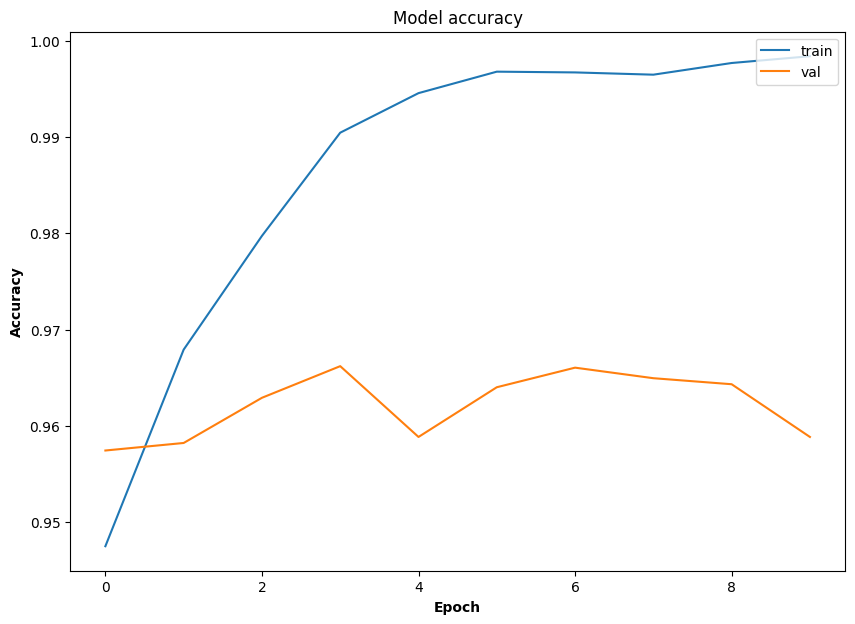

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(bertHistory.history['accuracy'])
plt.plot(bertHistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy', fontweight = "bold")
plt.xlabel('Epoch', fontweight = "bold")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

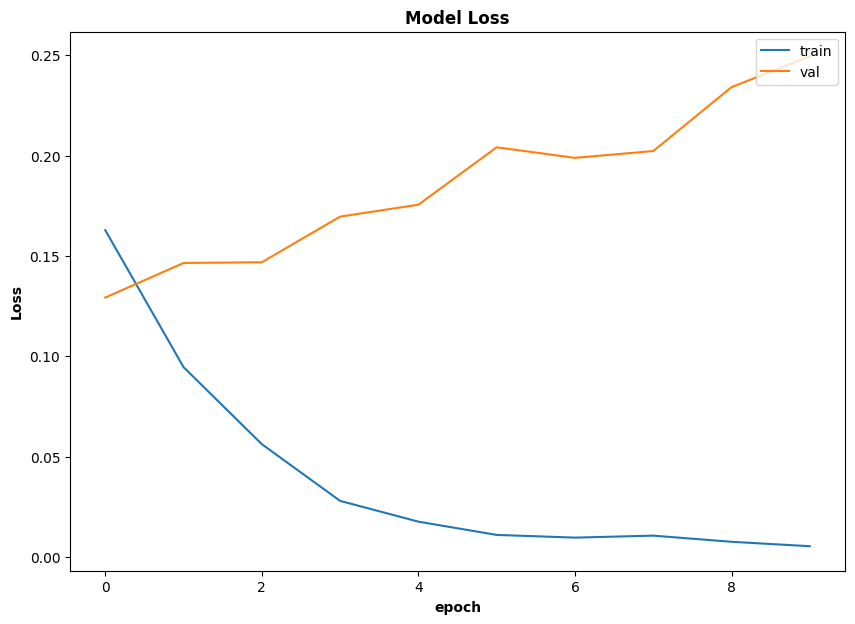

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(bertHistory.history['loss'])
plt.plot(bertHistory.history['val_loss'])
plt.title('Model Loss', fontweight = 'bold')
plt.ylabel('Loss', fontweight = "bold")
plt.xlabel('epoch', fontweight = "bold")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# Model evaluation function
def eval_model(predictions,y_val):
    print(accuracy_score(y_val, predictions))
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(np.array(y_val), np.array(predictions))
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_val, np.array(predictions), target_names=["Non-racist", "Racist"]))

In [ ]:
test_pred_all = bertClassifier.predict(X_val)

200/200 [==============================] - 13s 51ms/step


In [ ]:
tensor_test_predictions_all = tf.math.softmax(test_pred_all.logits, axis=1)
test_predictions_all = [list(bertClassifier.config.id2label.keys())[i] for i in tf.math.argmax(tensor_test_predictions_all, axis=1).numpy()]

0.9588612544971062


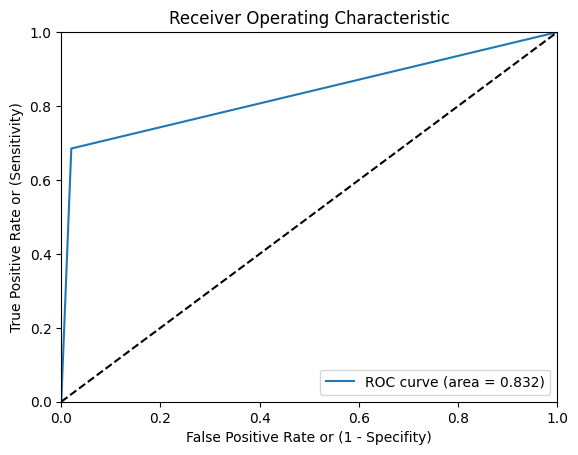

              precision    recall  f1-score   support

  Non-racist       0.98      0.98      0.98      5939
      Racist       0.72      0.69      0.70       454

    accuracy                           0.96      6393
   macro avg       0.85      0.83      0.84      6393
weighted avg       0.96      0.96      0.96      6393



In [ ]:
eval_model(test_predictions_all, y_val)


It can be seen that the model achieves a relatively high accuracy on this dataset, specifically 98% for non-racist sentences and 72% for racist sentences. This may be due to the significant imbalance in the number of non-racist and racist sentences.

# **Classification on test dataset**

In [ ]:
test_prediction = bertClassifier.predict(test_tokenised_text_df)
test_prediction = tf.math.softmax(test_prediction.logits, axis=1)
test_prediction = [list(bertClassifier.config.id2label.keys())[i] for i in tf.math.argmax(test_prediction, axis=1).numpy()]

df_test['prediction label'] = test_prediction


538/538 [==============================] - 27s 50ms/step


In [ ]:
df_test.head(100)

,id,tweet,preprocessed_tweet,prediction label
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolif aislif requir passion dedic willpow ...,0
1,31964,@user #white #supremacists want everyone to s...,white supremacist want everyon see new movi whi,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal acn altwaystoh healthi heal,0
3,31966,is the hp and the cursed child book up for res...,horsepower cur child book reserv alreadi ye ha...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",bihday amaz hilari nephew eli ahmir uncl dave ...,0
...,...,...,...,...
95,32058,great to see you! look forward to welcoming yo...,great see look forward welcom digm,0
96,32059,jackblair - na: #horny #hot #naughty #nasty ...,jackblair na horni hot naughti nasti slut youn...,0
97,32060,@user @user did u take both of them and pour t...,take pour one big cup drink deliv,0
98,32061,ððððâ¤ï¸ððð» happy fathe...,happi father day dad hope great day love fathe...,0
